# SpaceNet 9 - Satellite Coregistration EDA

This notebook performs exploratory data analysis on the SpaceNet 9 dataset for optical to SAR image registration.

## Dataset Overview
- **Task**: Cross-modal satellite imagery registration (Optical to SAR)
- **Data**: 3 regions with paired optical (RGB) and SAR images plus tiepoints
- **Resolution**: 0.3 - 0.5 meter cell size
- **Providers**: Maxar (optical), Umbra (SAR)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.plot import show, show_hist
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
# Define data paths
base_path = Path('../00_data/raw/train')
print(f"Base path: {base_path}")
print(f"Path exists: {base_path.exists()}")

# List all files
if base_path.exists():
    files = sorted(list(base_path.glob('*')))
    print("\nAvailable files:")
    for f in files:
        print(f"  - {f.name}")

Base path: ../../experiments/spacenet9/00_data/raw/train
Path exists: True

Available files:
  - 02_optical_train_01.tif
  - 02_optical_train_02.tif
  - 02_sar_train_01.tif
  - 02_sar_train_02.tif
  - 02_tiepoints_train_01.csv
  - 02_tiepoints_train_02.csv
  - 03_optical_train_01.tif
  - 03_sar_train_01.tif
  - 03_tiepoints_train_01.csv


## 1. Load and Analyze Image Metadata

In [3]:
def get_image_metadata(file_path):
    """Extract metadata from a GeoTIFF file"""
    with rasterio.open(file_path) as src:
        metadata = {
            'file': file_path.name,
            'width': src.width,
            'height': src.height,
            'bands': src.count,
            'dtype': src.dtypes[0],
            'crs': str(src.crs),
            'transform': src.transform,
            'bounds': src.bounds,
            'pixel_size': (src.transform[0], -src.transform[4])
        }
    return metadata

# Analyze all image files
image_files = list(base_path.glob('*.tif'))
metadata_list = []

for img_file in sorted(image_files):
    metadata = get_image_metadata(img_file)
    metadata_list.append(metadata)

# Create metadata dataframe
metadata_df = pd.DataFrame(metadata_list)
print("Image Metadata Summary:")
print(metadata_df[['file', 'width', 'height', 'bands', 'dtype', 'pixel_size']])

Image Metadata Summary:
                      file  width  height  bands  dtype  \
0  02_optical_train_01.tif  10155    3208      3  uint8   
1  02_optical_train_02.tif  10155    3990      3  uint8   
2      02_sar_train_01.tif   7477    2293      1  uint8   
3      02_sar_train_02.tif   7477    2929      1  uint8   
4  03_optical_train_01.tif   7740   10998      3  uint8   
5      03_sar_train_01.tif   5292    7520      1  uint8   

                                   pixel_size  
0              (0.30517578125, 0.30517578125)  
1              (0.30517578125, 0.30517578125)  
2  (0.40907031629718055, 0.40901647077815595)  
3  (0.40907031629718055, 0.40901647077815595)  
4   (0.3051517028133413, 0.30516529368974404)  
5     (0.446285004876463, 0.4462706703457085)  


## 2. Analyze Tiepoints

In [4]:
# Load all tiepoints
tiepoint_files = list(base_path.glob('*.csv'))
tiepoints_data = {}

for tp_file in sorted(tiepoint_files):
    df = pd.read_csv(tp_file)
    tiepoints_data[tp_file.stem] = df
    print(f"\n{tp_file.name}:")
    print(f"  - Number of tiepoints: {len(df)}")
    print(f"  - Columns: {list(df.columns)}")
    print(f"  - SAR range: rows [{df['sar_row'].min()}, {df['sar_row'].max()}], cols [{df['sar_col'].min()}, {df['sar_col'].max()}]")
    print(f"  - Optical range: rows [{df['optical_row'].min()}, {df['optical_row'].max()}], cols [{df['optical_col'].min()}, {df['optical_col'].max()}]")


02_tiepoints_train_01.csv:
  - Number of tiepoints: 151
  - Columns: ['sar_row', 'sar_col', 'optical_row', 'optical_col']
  - SAR range: rows [163, 2268], cols [166, 7352]
  - Optical range: rows [321, 3204], cols [436, 10041]

02_tiepoints_train_02.csv:
  - Number of tiepoints: 104
  - Columns: ['sar_row', 'sar_col', 'optical_row', 'optical_col']
  - SAR range: rows [0, 2747], cols [384, 7223]
  - Optical range: rows [11, 3750], cols [565, 9551]

03_tiepoints_train_01.csv:
  - Number of tiepoints: 161
  - Columns: ['sar_row', 'sar_col', 'optical_row', 'optical_col']
  - SAR range: rows [484, 7107], cols [0, 5182]
  - Optical range: rows [736, 10432], cols [89, 7617]


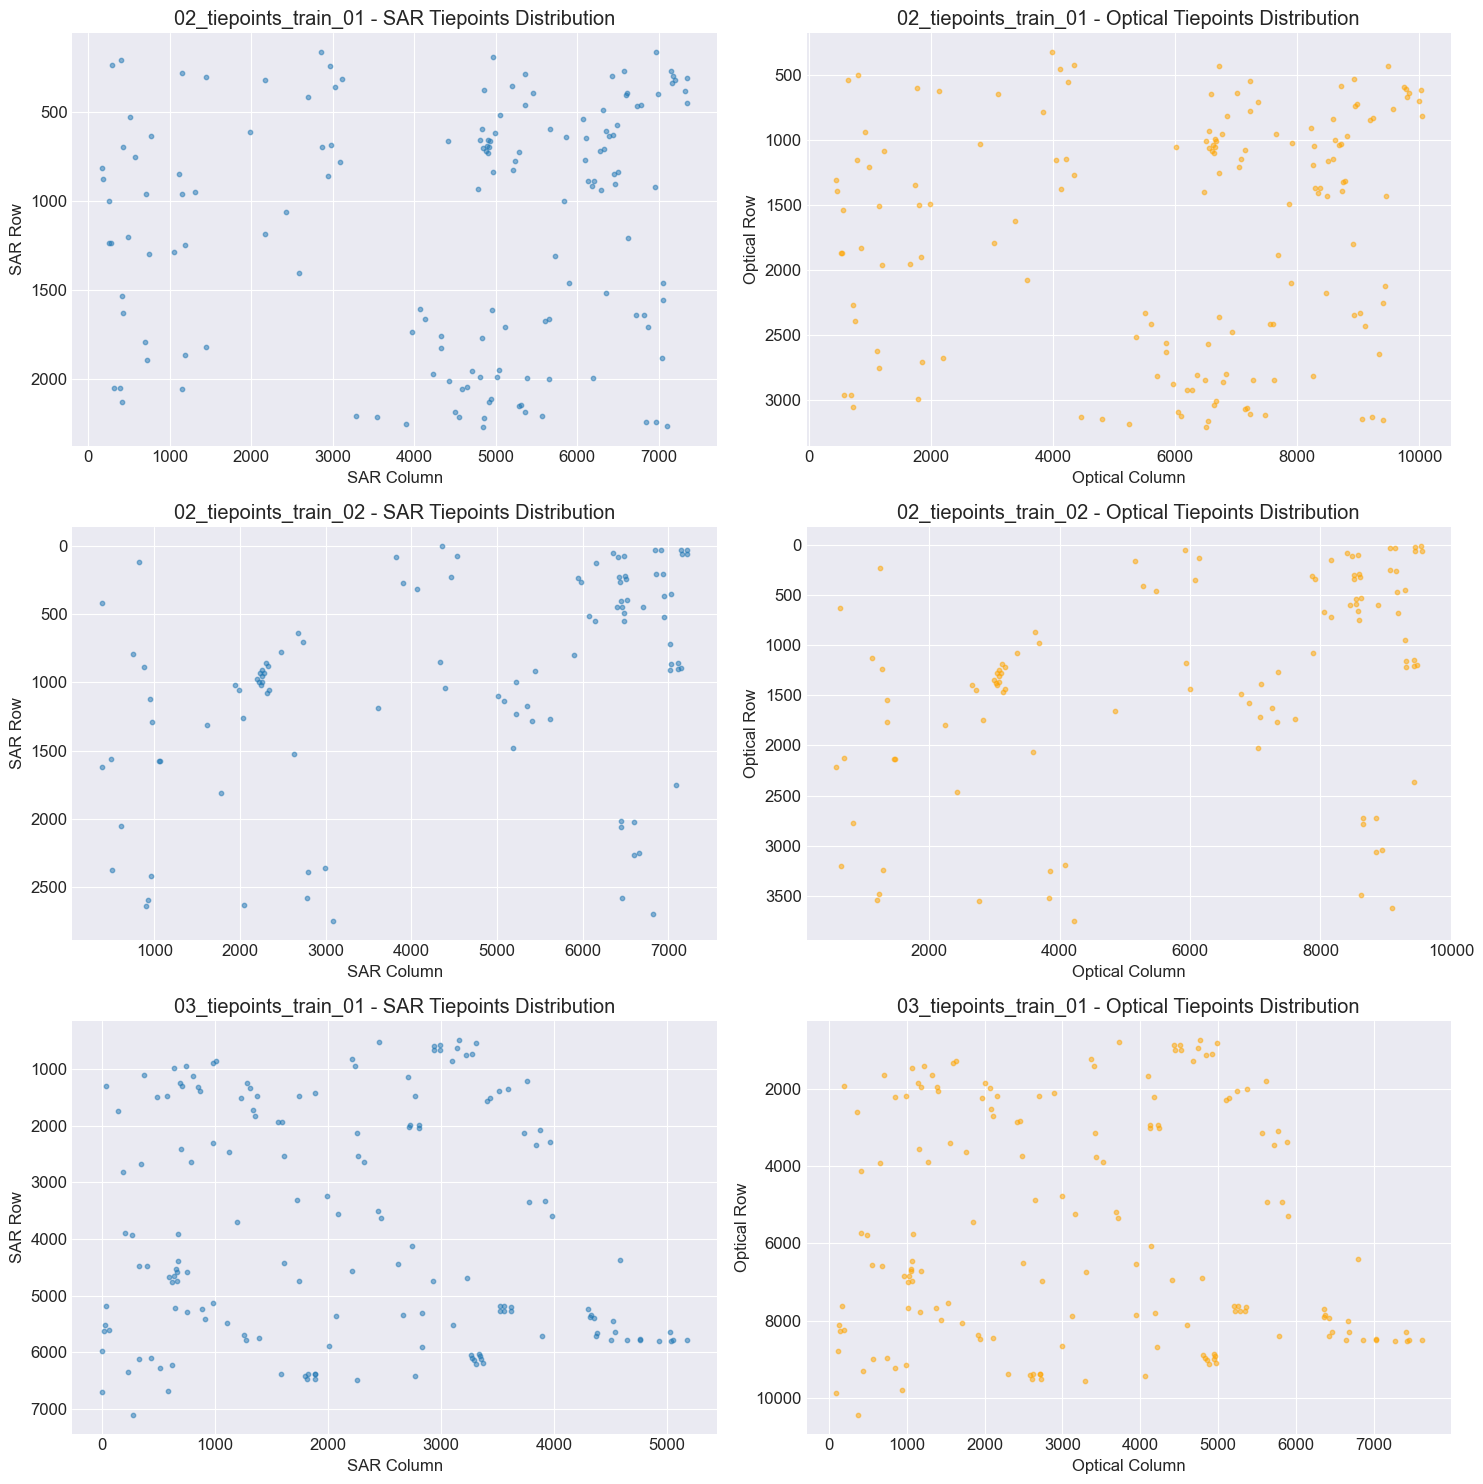

In [5]:
# Visualize tiepoint distributions
fig, axes = plt.subplots(len(tiepoints_data), 2, figsize=(15, 5*len(tiepoints_data)))
if len(tiepoints_data) == 1:
    axes = axes.reshape(1, -1)

for idx, (name, df) in enumerate(tiepoints_data.items()):
    # SAR tiepoints scatter
    ax1 = axes[idx, 0]
    ax1.scatter(df['sar_col'], df['sar_row'], alpha=0.5, s=10)
    ax1.set_xlabel('SAR Column')
    ax1.set_ylabel('SAR Row')
    ax1.set_title(f'{name} - SAR Tiepoints Distribution')
    ax1.invert_yaxis()
    
    # Optical tiepoints scatter
    ax2 = axes[idx, 1]
    ax2.scatter(df['optical_col'], df['optical_row'], alpha=0.5, s=10, color='orange')
    ax2.set_xlabel('Optical Column')
    ax2.set_ylabel('Optical Row')
    ax2.set_title(f'{name} - Optical Tiepoints Distribution')
    ax2.invert_yaxis()

plt.tight_layout()
plt.show()

## 3. Calculate Offsets and Statistics

In [6]:
# Calculate offsets for each tiepoint set
offset_stats = {}

for name, df in tiepoints_data.items():
    # Calculate offsets (optical -> SAR)
    df['offset_x'] = df['sar_col'] - df['optical_col']
    df['offset_y'] = df['sar_row'] - df['optical_row']
    df['offset_magnitude'] = np.sqrt(df['offset_x']**2 + df['offset_y']**2)
    
    stats = {
        'mean_offset_x': df['offset_x'].mean(),
        'std_offset_x': df['offset_x'].std(),
        'mean_offset_y': df['offset_y'].mean(),
        'std_offset_y': df['offset_y'].std(),
        'mean_magnitude': df['offset_magnitude'].mean(),
        'std_magnitude': df['offset_magnitude'].std(),
        'min_magnitude': df['offset_magnitude'].min(),
        'max_magnitude': df['offset_magnitude'].max()
    }
    offset_stats[name] = stats

# Display offset statistics
offset_stats_df = pd.DataFrame(offset_stats).T
print("Offset Statistics (pixels):")
print(offset_stats_df.round(2))

Offset Statistics (pixels):
                       mean_offset_x  std_offset_x  mean_offset_y  \
02_tiepoints_train_01       -1587.91        708.79        -560.67   
02_tiepoints_train_02       -1488.26        733.35        -359.91   
03_tiepoints_train_01       -1107.09        658.28       -1811.83   

                       std_offset_y  mean_magnitude  std_magnitude  \
02_tiepoints_train_01        231.32         1734.33         618.58   
02_tiepoints_train_02        272.63         1593.62         644.25   
03_tiepoints_train_01        941.19         2255.53         858.22   

                       min_magnitude  max_magnitude  
02_tiepoints_train_01         452.02        2713.12  
02_tiepoints_train_02         327.57        2450.56  
03_tiepoints_train_01         631.45        3641.03  


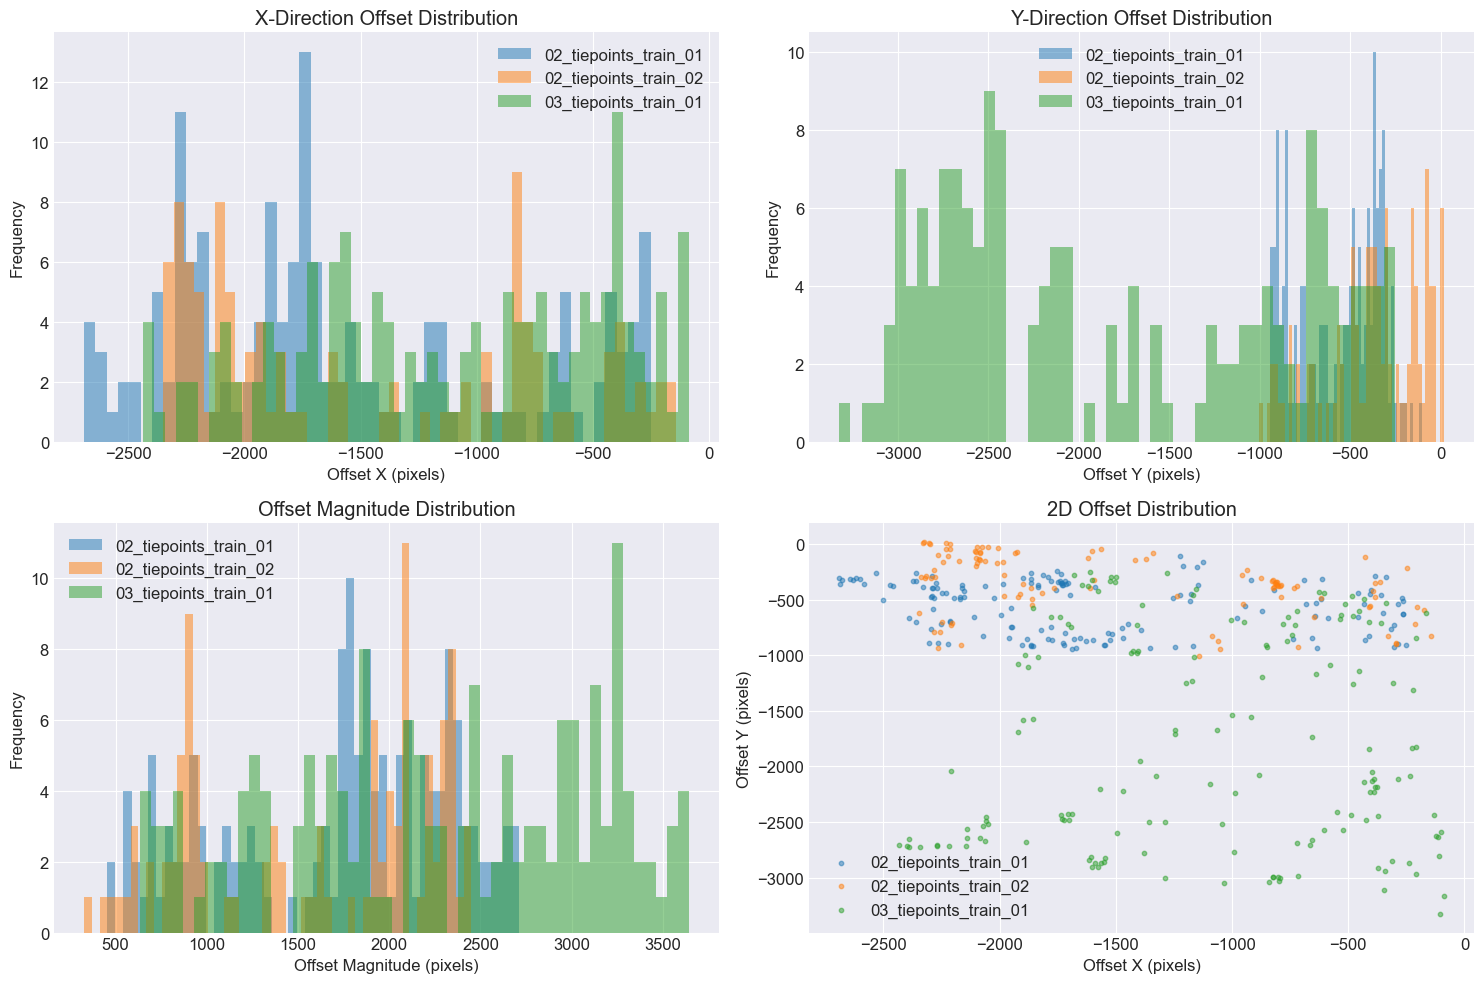

In [7]:
# Visualize offset distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Offset X distribution
ax1 = axes[0, 0]
for name, df in tiepoints_data.items():
    ax1.hist(df['offset_x'], bins=50, alpha=0.5, label=name)
ax1.set_xlabel('Offset X (pixels)')
ax1.set_ylabel('Frequency')
ax1.set_title('X-Direction Offset Distribution')
ax1.legend()

# Offset Y distribution
ax2 = axes[0, 1]
for name, df in tiepoints_data.items():
    ax2.hist(df['offset_y'], bins=50, alpha=0.5, label=name)
ax2.set_xlabel('Offset Y (pixels)')
ax2.set_ylabel('Frequency')
ax2.set_title('Y-Direction Offset Distribution')
ax2.legend()

# Offset magnitude distribution
ax3 = axes[1, 0]
for name, df in tiepoints_data.items():
    ax3.hist(df['offset_magnitude'], bins=50, alpha=0.5, label=name)
ax3.set_xlabel('Offset Magnitude (pixels)')
ax3.set_ylabel('Frequency')
ax3.set_title('Offset Magnitude Distribution')
ax3.legend()

# 2D offset scatter
ax4 = axes[1, 1]
for name, df in tiepoints_data.items():
    ax4.scatter(df['offset_x'], df['offset_y'], alpha=0.5, s=10, label=name)
ax4.set_xlabel('Offset X (pixels)')
ax4.set_ylabel('Offset Y (pixels)')
ax4.set_title('2D Offset Distribution')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

## 4. Visualize Sample Images

In [8]:
# Load and display sample images from region 02_01
optical_path = base_path / '02_optical_train_01.tif'
sar_path = base_path / '02_sar_train_01.tif'
tiepoints = tiepoints_data['02_tiepoints_train_01']

# Read images
with rasterio.open(optical_path) as src:
    optical_img = src.read()
    optical_transform = src.transform

with rasterio.open(sar_path) as src:
    sar_img = src.read(1)  # Single band
    sar_transform = src.transform

print(f"Optical image shape: {optical_img.shape}")
print(f"SAR image shape: {sar_img.shape}")

Optical image shape: (3, 3208, 10155)
SAR image shape: (2293, 7477)


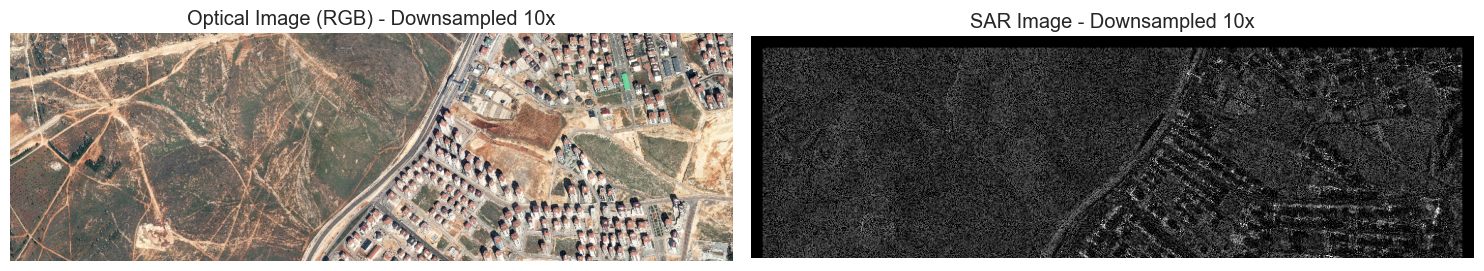

In [9]:
# Display full images with downsampling for visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Optical image (RGB)
# Downsample for visualization
downsample_factor = 10
optical_vis = optical_img[:, ::downsample_factor, ::downsample_factor]
optical_vis = np.moveaxis(optical_vis, 0, -1)  # Channel last for RGB display

# Normalize for display
optical_vis = (optical_vis - optical_vis.min()) / (optical_vis.max() - optical_vis.min())

ax1.imshow(optical_vis)
ax1.set_title('Optical Image (RGB) - Downsampled 10x')
ax1.axis('off')

# SAR image
sar_vis = sar_img[::downsample_factor, ::downsample_factor]
ax2.imshow(sar_vis, cmap='gray')
ax2.set_title('SAR Image - Downsampled 10x')
ax2.axis('off')

plt.tight_layout()
plt.show()

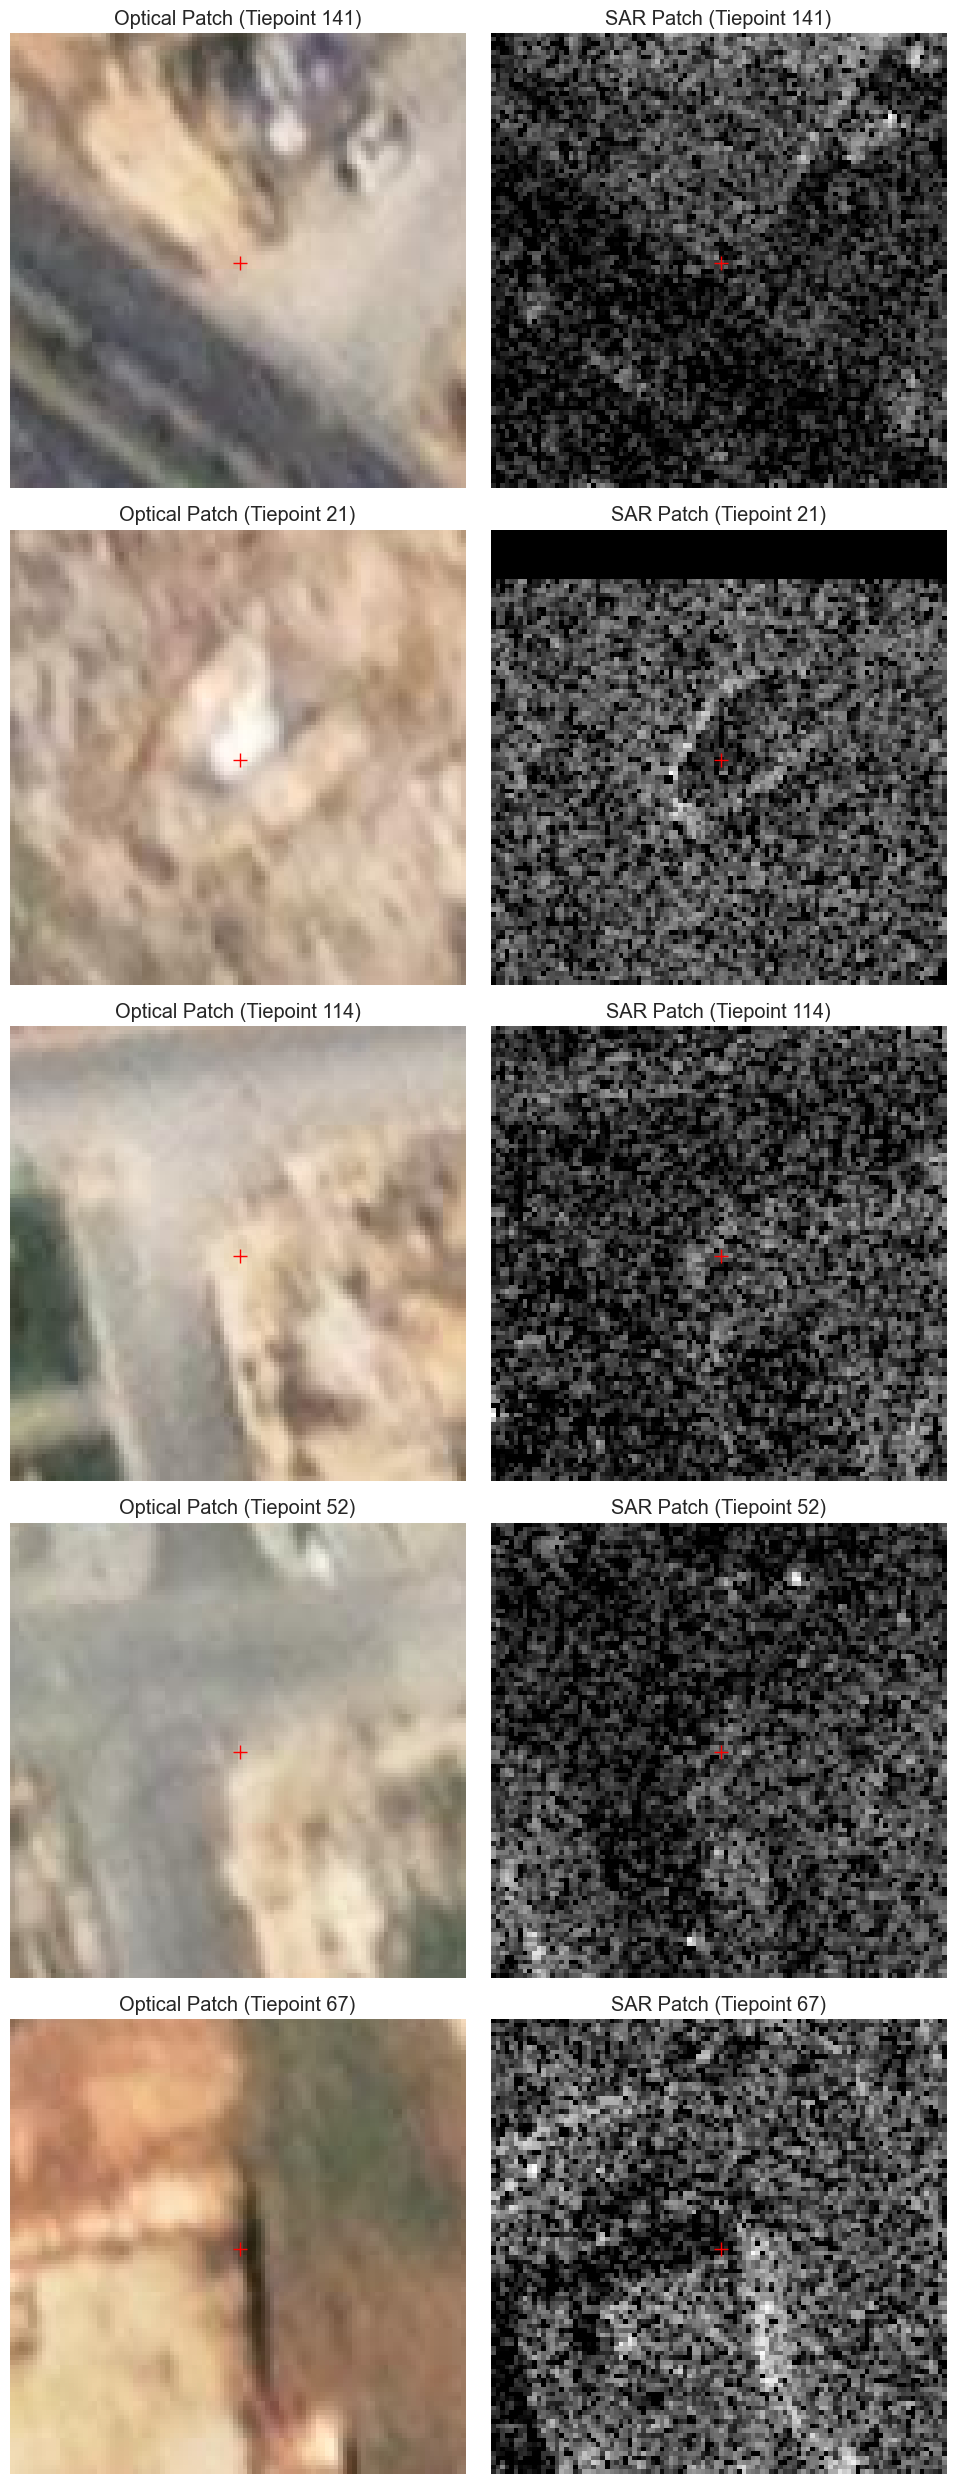

In [10]:
# Visualize sample tiepoint patches
n_samples = 5
patch_size = 100  # pixels
sample_indices = np.random.choice(len(tiepoints), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 2, figsize=(10, 5*n_samples))

for i, idx in enumerate(sample_indices):
    tp = tiepoints.iloc[idx]
    
    # Extract optical patch
    opt_row, opt_col = int(tp['optical_row']), int(tp['optical_col'])
    opt_r1 = max(0, opt_row - patch_size//2)
    opt_r2 = min(optical_img.shape[1], opt_row + patch_size//2)
    opt_c1 = max(0, opt_col - patch_size//2)
    opt_c2 = min(optical_img.shape[2], opt_col + patch_size//2)
    
    optical_patch = optical_img[:, opt_r1:opt_r2, opt_c1:opt_c2]
    optical_patch = np.moveaxis(optical_patch, 0, -1)
    
    # Extract SAR patch
    sar_row, sar_col = int(tp['sar_row']), int(tp['sar_col'])
    sar_r1 = max(0, sar_row - patch_size//2)
    sar_r2 = min(sar_img.shape[0], sar_row + patch_size//2)
    sar_c1 = max(0, sar_col - patch_size//2)
    sar_c2 = min(sar_img.shape[1], sar_col + patch_size//2)
    
    sar_patch = sar_img[sar_r1:sar_r2, sar_c1:sar_c2]
    
    # Display patches
    axes[i, 0].imshow(optical_patch)
    axes[i, 0].plot(patch_size//2, patch_size//2, 'r+', markersize=10)
    axes[i, 0].set_title(f'Optical Patch (Tiepoint {idx})')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(sar_patch, cmap='gray')
    axes[i, 1].plot(patch_size//2, patch_size//2, 'r+', markersize=10)
    axes[i, 1].set_title(f'SAR Patch (Tiepoint {idx})')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

## 5. Image Statistics

In [11]:
# Calculate image statistics for all images
image_stats = []

for img_file in sorted(image_files):
    with rasterio.open(img_file) as src:
        data = src.read()
        
        stats = {
            'file': img_file.name,
            'type': 'optical' if 'optical' in img_file.name else 'sar',
            'region': img_file.name.split('_')[0],
            'min': data.min(),
            'max': data.max(),
            'mean': data.mean(),
            'std': data.std(),
            'median': np.median(data),
            'q25': np.percentile(data, 25),
            'q75': np.percentile(data, 75)
        }
        
        if 'optical' in img_file.name:
            # Per-channel stats for RGB
            for i, channel in enumerate(['red', 'green', 'blue']):
                stats[f'{channel}_mean'] = data[i].mean()
                stats[f'{channel}_std'] = data[i].std()
        
        image_stats.append(stats)

# Create statistics dataframe
stats_df = pd.DataFrame(image_stats)
print("\nImage Statistics Summary:")
print(stats_df[['file', 'type', 'min', 'max', 'mean', 'std']].round(2))


Image Statistics Summary:
                      file     type  min  max    mean    std
0  02_optical_train_01.tif  optical    0  255  136.72  50.43
1  02_optical_train_02.tif  optical    0  255  141.21  55.86
2      02_sar_train_01.tif      sar    0  255   39.56  32.96
3      02_sar_train_02.tif      sar    0  255   43.71  42.02
4  03_optical_train_01.tif  optical    0  255   69.23  74.04
5      03_sar_train_01.tif      sar    0  255   36.69  39.68


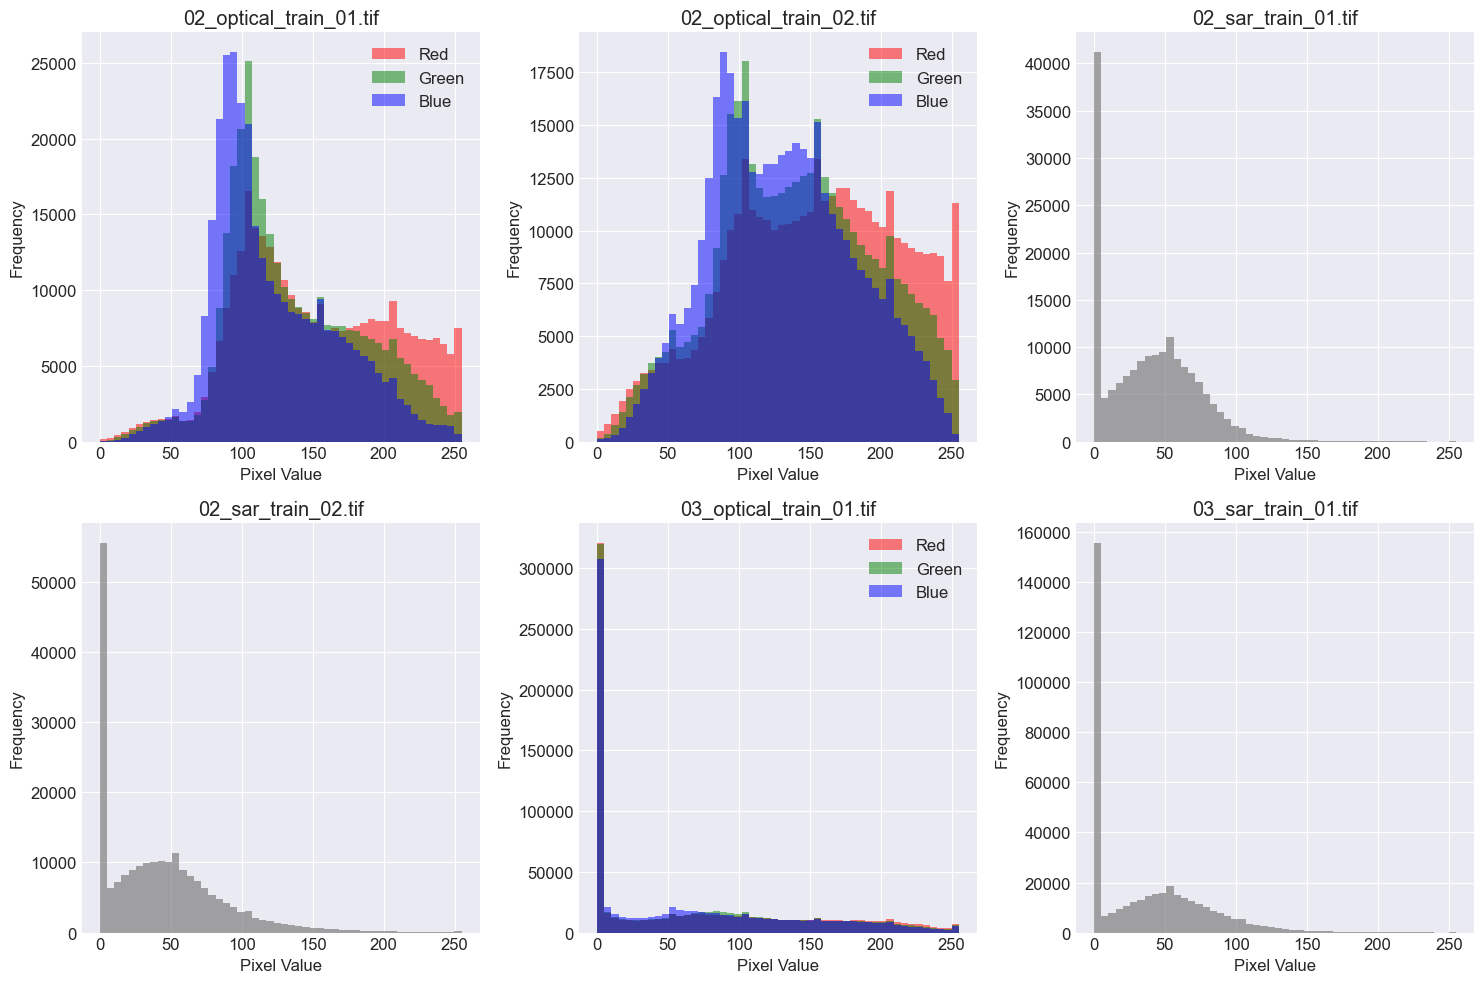

In [12]:
# Plot histograms for pixel value distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, img_file in enumerate(sorted(image_files)[:6]):
    with rasterio.open(img_file) as src:
        data = src.read()
        
    ax = axes[idx]
    
    if 'optical' in img_file.name:
        # Plot histogram for each channel
        for i, (channel, color) in enumerate(zip(['Red', 'Green', 'Blue'], ['red', 'green', 'blue'])):
            ax.hist(data[i].flatten()[::100], bins=50, alpha=0.5, color=color, label=channel)
        ax.legend()
    else:
        # SAR image histogram
        ax.hist(data.flatten()[::100], bins=50, color='gray', alpha=0.7)
    
    ax.set_title(img_file.name)
    ax.set_xlabel('Pixel Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 6. Summary and Key Findings

In [13]:
# Summary statistics
print("=== SpaceNet 9 Dataset Summary ===")
print(f"\nTotal number of image pairs: {len(image_files)//2}")
print(f"Total number of tiepoint files: {len(tiepoint_files)}")

total_tiepoints = sum(len(df) for df in tiepoints_data.values())
print(f"Total number of tiepoints: {total_tiepoints}")

print("\n=== Image Properties ===")
for _, row in metadata_df.iterrows():
    print(f"\n{row['file']}:")
    print(f"  - Size: {row['width']} x {row['height']} pixels")
    print(f"  - Bands: {row['bands']}")
    print(f"  - Pixel size: {row['pixel_size']} meters")

print("\n=== Offset Statistics Summary ===")
print(f"Average offset magnitude across all regions: {offset_stats_df['mean_magnitude'].mean():.2f} ± {offset_stats_df['std_magnitude'].mean():.2f} pixels")
print(f"Maximum offset magnitude: {offset_stats_df['max_magnitude'].max():.2f} pixels")
print(f"Minimum offset magnitude: {offset_stats_df['min_magnitude'].min():.2f} pixels")

=== SpaceNet 9 Dataset Summary ===

Total number of image pairs: 3
Total number of tiepoint files: 3
Total number of tiepoints: 416

=== Image Properties ===

02_optical_train_01.tif:
  - Size: 10155 x 3208 pixels
  - Bands: 3
  - Pixel size: (0.30517578125, 0.30517578125) meters

02_optical_train_02.tif:
  - Size: 10155 x 3990 pixels
  - Bands: 3
  - Pixel size: (0.30517578125, 0.30517578125) meters

02_sar_train_01.tif:
  - Size: 7477 x 2293 pixels
  - Bands: 1
  - Pixel size: (0.40907031629718055, 0.40901647077815595) meters

02_sar_train_02.tif:
  - Size: 7477 x 2929 pixels
  - Bands: 1
  - Pixel size: (0.40907031629718055, 0.40901647077815595) meters

03_optical_train_01.tif:
  - Size: 7740 x 10998 pixels
  - Bands: 3
  - Pixel size: (0.3051517028133413, 0.30516529368974404) meters

03_sar_train_01.tif:
  - Size: 5292 x 7520 pixels
  - Bands: 1
  - Pixel size: (0.446285004876463, 0.4462706703457085) meters

=== Offset Statistics Summary ===
Average offset magnitude across all regi

## 7. Spatial Offset Analysis

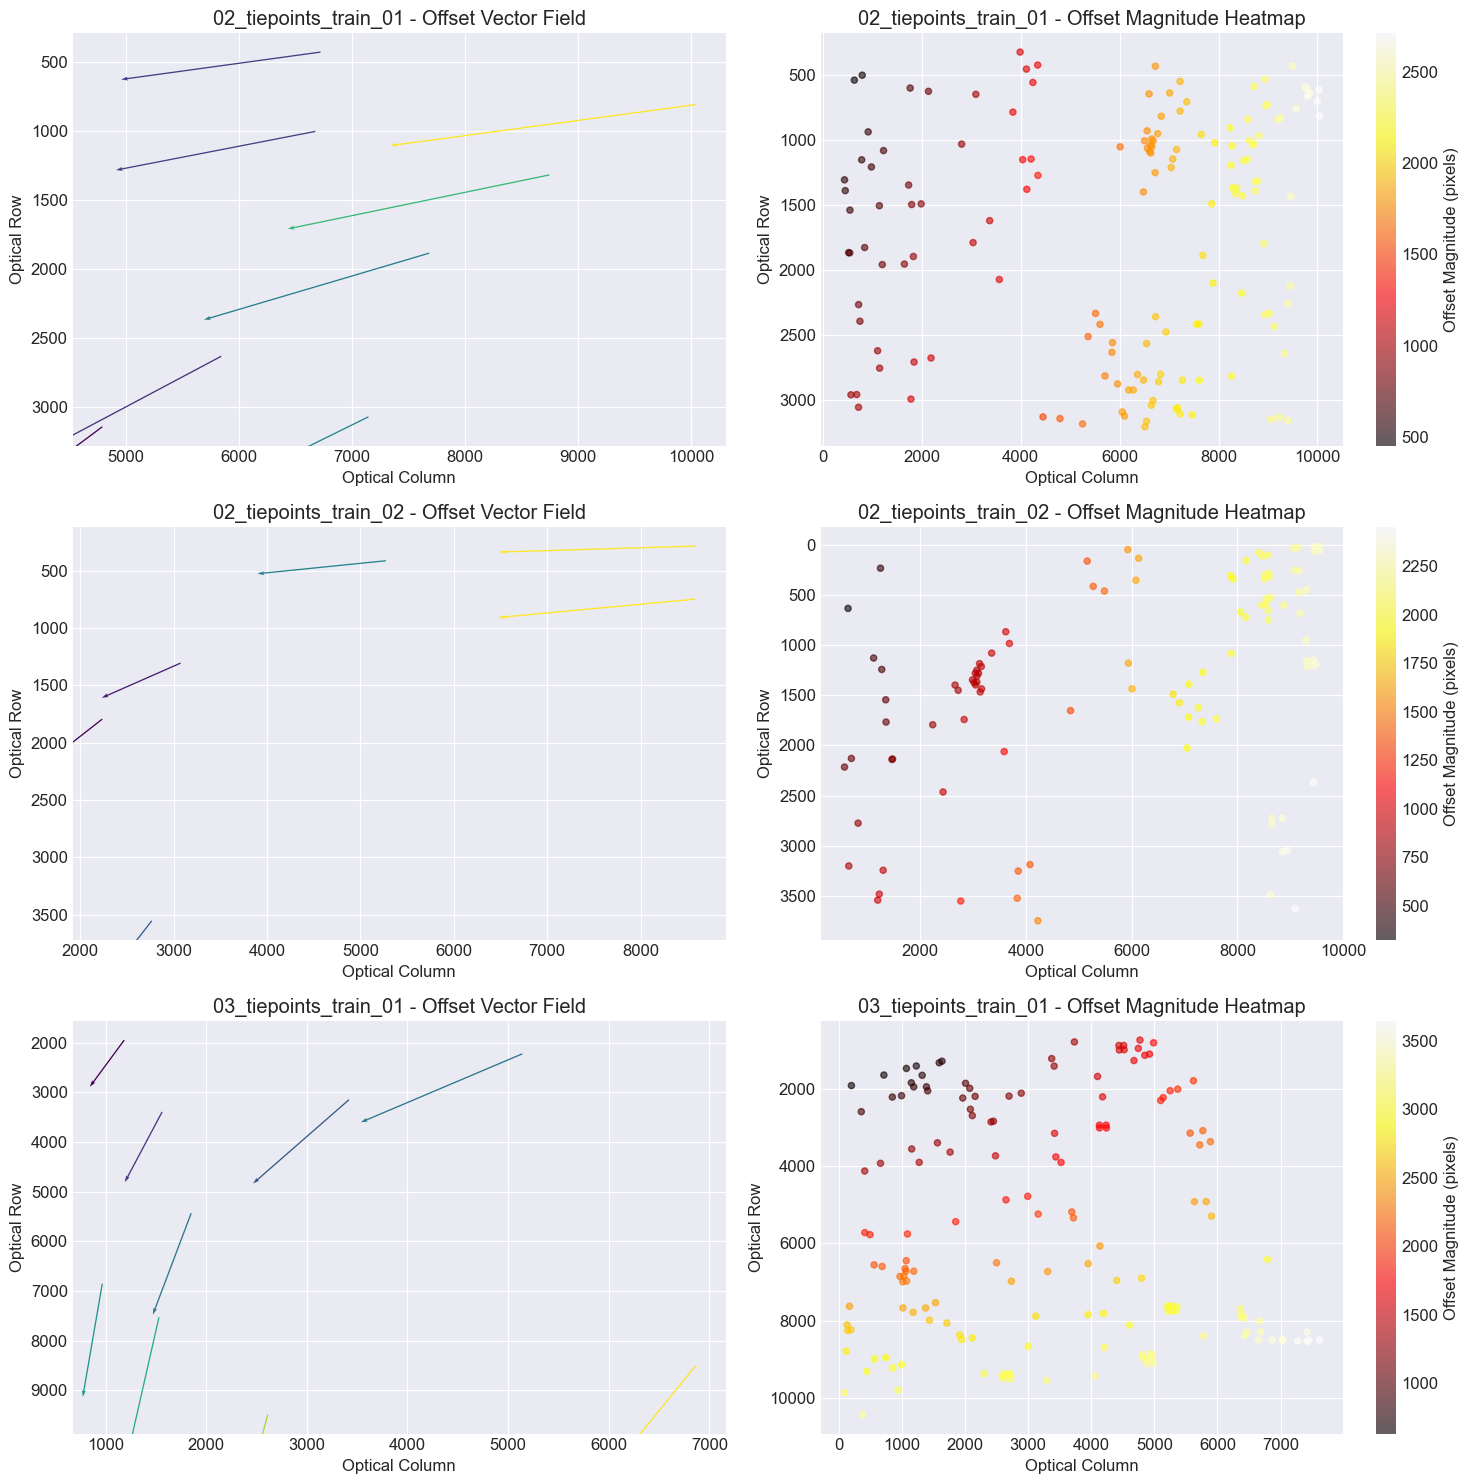

In [14]:
# Analyze spatial variation of offsets
fig, axes = plt.subplots(len(tiepoints_data), 2, figsize=(15, 5*len(tiepoints_data)))
if len(tiepoints_data) == 1:
    axes = axes.reshape(1, -1)

for idx, (name, df) in enumerate(tiepoints_data.items()):
    # Create a quiver plot showing offset vectors
    ax1 = axes[idx, 0]
    
    # Subsample for visualization
    subsample = 20
    df_sub = df.iloc[::subsample]
    
    ax1.quiver(df_sub['optical_col'], df_sub['optical_row'], 
               df_sub['offset_x'], df_sub['offset_y'],
               df_sub['offset_magnitude'], cmap='viridis',
               scale_units='xy', scale=1, width=0.002)
    
    ax1.set_xlabel('Optical Column')
    ax1.set_ylabel('Optical Row')
    ax1.set_title(f'{name} - Offset Vector Field')
    ax1.invert_yaxis()
    
    # Heatmap of offset magnitude
    ax2 = axes[idx, 1]
    scatter = ax2.scatter(df['optical_col'], df['optical_row'], 
                         c=df['offset_magnitude'], cmap='hot',
                         s=20, alpha=0.6)
    plt.colorbar(scatter, ax=ax2, label='Offset Magnitude (pixels)')
    ax2.set_xlabel('Optical Column')
    ax2.set_ylabel('Optical Row')
    ax2.set_title(f'{name} - Offset Magnitude Heatmap')
    ax2.invert_yaxis()

plt.tight_layout()
plt.show()

## 8. Recommendations for Model Development

Based on the EDA findings:

1. **Large Offsets**: The offsets between optical and SAR images are substantial (hundreds of pixels), indicating significant misalignment
2. **Spatial Variation**: Offsets vary across the image, suggesting non-rigid transformation
3. **Multi-modal Challenge**: RGB optical vs single-channel SAR requires robust feature extraction
4. **Data Distribution**: Tiepoints are well-distributed across images, providing good coverage

### Suggested Approaches:
- Deep learning-based feature matching (e.g., SuperGlue, LoFTR)
- Multi-scale feature extraction to handle large offsets
- Attention mechanisms for cross-modal matching
- Dense prediction networks for pixel-wise offset estimation